In [1]:
!pip install --pre torchaudio -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [2]:
%matplotlib inline

import os
from copy import copy
from dataclasses import dataclass

import requests
import matplotlib
import matplotlib.pyplot as plt

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

import torch
import torchaudio

SPEECH_URL = 'https://download.pytorch.org/torchaudio/test-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.flac'
SPEECH_FILE = 'speech.flac'

if not os.path.exists(SPEECH_FILE):
  with open(SPEECH_FILE, 'wb') as file:
    with requests.get(SPEECH_URL) as resp:
      resp.raise_for_status()
      file.write(resp.content)

import IPython

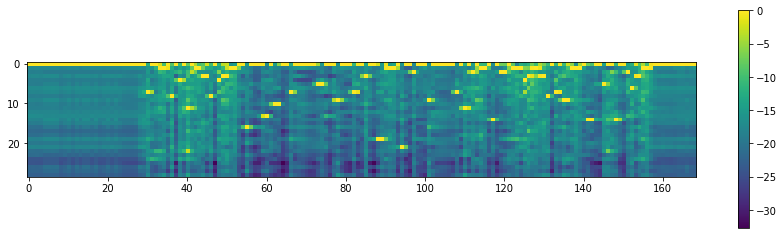

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model()
with torch.inference_mode():
  waveform, _ = torchaudio.load(SPEECH_FILE)
  emissions, _ = model(waveform)
  emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

plt.imshow(emission.T)
plt.colorbar()
plt.show()


[('I', 7), ('|', 1), ('H', 8), ('A', 4), ('D', 11), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('T', 3), ('|', 1), ('C', 16), ('U', 13), ('R', 10), ('I', 7), ('O', 5), ('S', 9), ('I', 7), ('T', 3), ('Y', 19), ('|', 1), ('B', 21), ('E', 2), ('S', 9), ('I', 7), ('D', 11), ('E', 2), ('|', 1), ('M', 14), ('E', 2), ('|', 1), ('A', 4), ('T', 3), ('|', 1), ('T', 3), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('M', 14), ('O', 5), ('M', 14), ('E', 2), ('N', 6), ('T', 3), ('|', 1)]


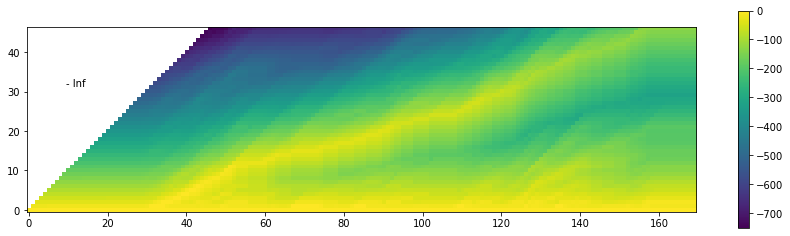

In [4]:
transcript = 'I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|'
dictionary  = {c: i for i, c in enumerate(bundle.get_labels())}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

def get_trellis(emission, tokens, blank_id=0):
  num_frame = emission.size(0)
  num_tokens = len(tokens)

  # Trellis has extra diemsions for both time axis and tokens.
  # The extra dim for tokens represents <SoS> (start-of-sentence)
  # The extra dim for time axis is for simplification of the code. 
  trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
  trellis[:, 0] = 0
  for t in range(num_frame):
    trellis[t+1, 1:] = torch.maximum(
        # Score for staying at the same token
        trellis[t, 1:] + emission[t, blank_id],
        # Score for changing to the next token
        trellis[t, :-1] + emission[t, tokens],
    )
  return trellis

trellis = get_trellis(emission, tokens)

################################################################################
# Visualization
################################################################################
plt.imshow(trellis.T, origin='lower')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()


[Point(token_index=0, time_index=30, score=0.9999842643737793), Point(token_index=0, time_index=31, score=0.9847016334533691), Point(token_index=0, time_index=32, score=0.9999707937240601), Point(token_index=0, time_index=33, score=0.15400736033916473), Point(token_index=1, time_index=34, score=0.9999173879623413), Point(token_index=1, time_index=35, score=0.6080495119094849), Point(token_index=2, time_index=36, score=0.9997718930244446), Point(token_index=2, time_index=37, score=0.9997127652168274), Point(token_index=3, time_index=38, score=0.9999357461929321), Point(token_index=3, time_index=39, score=0.9861611127853394), Point(token_index=4, time_index=40, score=0.9238567352294922), Point(token_index=4, time_index=41, score=0.9257279634475708), Point(token_index=4, time_index=42, score=0.015661610290408134), Point(token_index=5, time_index=43, score=0.9998378753662109), Point(token_index=6, time_index=44, score=0.9988443851470947), Point(token_index=6, time_index=45, score=0.1014751

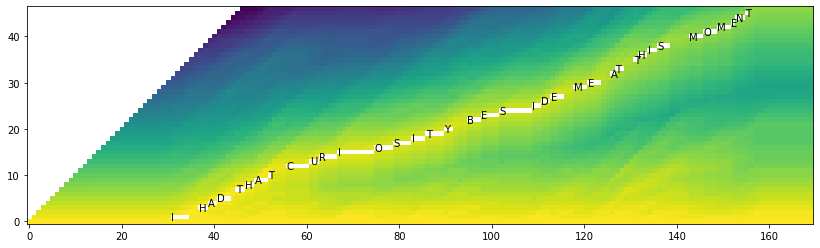

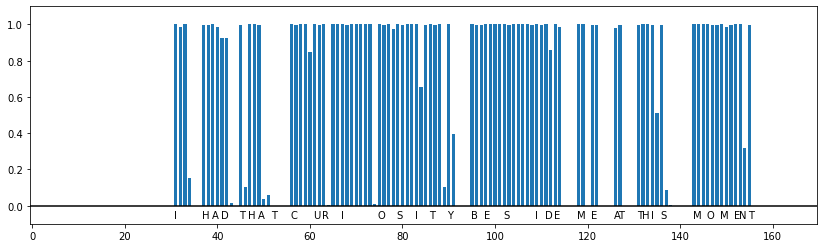

In [5]:
@dataclass
class Point:
  token_index: int
  time_index: int
  score: float


def backtrack(trellis, emission, tokens, blank_id=0):
  # Note:
  # c and t are indices for trellis, which has extra dimensions 
  # for time and tokens at the beginning.
  # When refering to time frame index `T` in trellis,
  # the corresponding index in emission is `T-1`.
  # Similarly, when refering to token index `C` in trellis,
  # the corresponding index in transcript is `C-1`.
  c = trellis.size(1) - 1
  t_start = torch.argmax(trellis[:, c]).item()

  path = []
  for t in range(t_start, 0, -1):
    # 1. Figure out if the current position was stay or change
    # Note (again):
    # `emission[T-1]` is the emission at time frame `T` of trellis dimension.
    # Score for token staying the same from time frame T-1 to T.
    stayed = trellis[t-1, c] + emission[t-1, blank_id]
    # Score for token changing from C-1 at T-1 to C at T.
    changed = trellis[t-1, c-1] + emission[t-1, tokens[c-1]]

    # 2. Store the path with frame-wise probability.
    prob = emission[t-1, tokens[c-1] if changed > stayed else 0].exp().item()
    # Return token index and time index in non-trellis coordinate.
    path.append(Point(c-1, t-1, prob))

    # 3. Update the token
    if changed > stayed:
      c -= 1
      if c == 0:
        break
  else:
    raise ValueError('Failed to align')
  return path[::-1]

path = backtrack(trellis, emission, tokens)
print(path)

# Merge the labels
@dataclass
class Segment:
  label: str
  start: int
  end: int
  score: float

  def __repr__(self):
    return f"{self.label} ({self.score:.2f}): [{self.start}, {self.end})"

  @property
  def length(self):
    return self.end - self.start

def merge_repeats(path):
  i, j = 0, 0
  segments = []
  while i < len(path):
    while j < len(path) and path[i].token_index == path[j].token_index:
      j += 1
    score = sum(path[k].score for k in range(i, j)) / (j - i)
    segments.append(Segment(transcript[path[i].token_index], path[i].time_index, path[j-1].time_index + 1, score))
    i = j
  return segments

segments = merge_repeats(path)
for seg in segments:
  print(seg)

################################################################################
# visualization
################################################################################
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  plt.figure()
  ax1 = plt.axes()
  ax1.imshow(trellis_with_path.T, origin='lower')

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start + .7, i + 0.3))
  
  plt.figure()
  ax2 = plt.axes()
  xs, heights = [], []
  for p in path:
    label = transcript[p.token_index]
    if label != '|':
      xs.append(p.time_index + 1)
      heights.append(p.score)
  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax2.annotate(seg.label, (seg.start + .7, -0.07))

  ax2.bar(xs, heights, width=0.7)
  ax2.axhline(0, color='black')
  ax2.set_position(ax1.get_position())
  ax2.set_xlim(ax1.get_xlim())
  ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis, segments, transcript)
plt.show()

[I (0.78): [30, 34), HAD (0.84): [36, 43), THAT (0.52): [44, 52), CURIOSITY (0.89): [55, 91), BESIDE (0.94): [94, 115), ME (0.67): [117, 123), AT (0.66): [125, 128), THIS (0.70): [130, 138), MOMENT (0.95): [142, 155)]


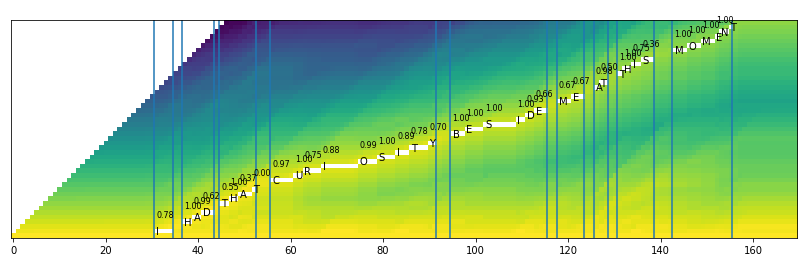

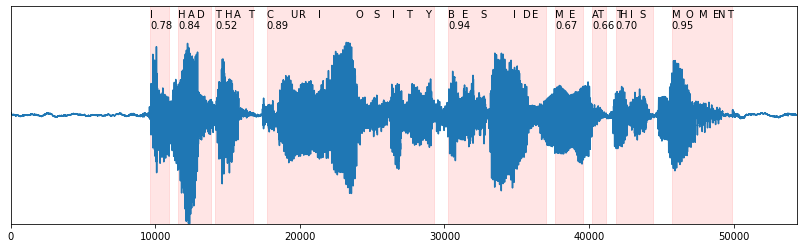

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


I: 0.604 - 0.684


HAD: 0.724 - 0.865


THAT: 0.885 - 1.046


CURIOSITY: 1.107 - 1.831


BESIDE: 1.891 - 2.314


ME: 2.354 - 2.474


AT: 2.515 - 2.575


THIS: 2.615 - 2.776


MOMENT: 2.857 - 3.118


In [6]:
# Merge words
def merge_words(segments, separator='|'):
  words = []
  i, j = 0, 0
  while i < len(segments):
    seg = segments[j]
    if seg.label != separator:
      j += 1
    else:
      if i != j:
        segs = segments[i:j]
        word = ''.join([seg.label for seg in segs])
        score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
        words.append(Segment(word, segments[i].start, segments[j-1].end, score))
      i = j + 1
      j = i
  return words

word_segments = merge_words(segments)
print(word_segments)

################################################################################
# visualization
################################################################################
trellis_with_path = trellis.clone()
for i, seg in enumerate(segments):
  if seg.label != '|':
    trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

plt.imshow(trellis_with_path.T, origin='lower')
ax1 = plt.gca()
ax1.set_yticks([])

for word in word_segments:
  plt.axvline(word.start + 0.5)
  plt.axvline(word.end + 0.5)

for i, seg in enumerate(segments):
  if seg.label != '|':
    plt.annotate(seg.label, (seg.start + 1, i + 0.3))
    plt.annotate(f'{seg.score:.2f}', (seg.start + 1, i + 4), fontsize=8)

plt.show()

# The original waveform
ratio = waveform.size(1) / (trellis.size(0) - 1)
plt.plot(waveform[0])
for word in word_segments:
  x0 = ratio * word.start
  x1 = ratio * word.end
  plt.axvspan(x0, x1, alpha=0.1, color='red')
  plt.annotate(f'{word.score:.2f}', (x0, 0.8))

for seg in segments:
  if seg.label != '|':
    plt.annotate(seg.label, (seg.start * ratio, 0.9))

ax2 = plt.gca()
ax2.set_position(ax1.get_position())
ax2.set_yticks([])
ax2.set_ylim(-1.0, 1.0)
ax2.set_xlim(0, waveform.size(-1))
plt.show()

# Generate the audio for each segment
print(transcript)
IPython.display.display(IPython.display.Audio(SPEECH_FILE))
for i, word in enumerate(word_segments):
  x0 = int(ratio * word.start)
  x1 = int(ratio * word.end)
  filename = f"{i}_{word.label}.wav"
  torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
  print(f"{word.label}: {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f}")
  IPython.display.display(IPython.display.Audio(filename))